In [1]:
# The final Model of Delta Risk Model (with Vega also calculated)

# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import PredictionErrorDisplay
import statsmodels.api as sm
import lightgbm as lgb

In [2]:
# Display Options of DataFrame
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
# Loading Swap Rate Dataset
data = pd.read_csv("../cleanedDataIR/irwithevol.csv")

In [4]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Value Date', 'Trade Name',
       'Trade Currency', 'Zero Rate Shock', 'Zero Rate Shock (DEC)', 'TV',
       'Expiry Bucket', 'Expiry Date', 'Tenor Bucket', 'Vega', 'CMS Tenor',
       'Swap Rate', 'Swap Rate (Shocked)', 'lower_bound', 'upper_bound',
       'bound width', 'month_pay_frequency', 'year_maturity',
       'Distance_lower (Shocked)', 'Distance_upper (Shocked)', 'Out of Bound',
       'Swap_Bound Distance', 'Vols', 'Swap Rate_f', 'Swap Rate_f(shocked)',
       'pre', 'prer', 'prev', 'evol'],
      dtype='object')

In [5]:
data = data.drop(columns = ['Swap Rate_f', 'Swap Rate_f(shocked)','pre', 'prer', 'prev'])


In [6]:
data = data.drop(columns = {'Unnamed: 0.1', 'Unnamed: 0'})
data

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,evol
0,2022-09-02,dummyTrade1,USD,-100,-0.01000,-227907.09877,1.00000,2023-09-04,10.00000,1.96225,2,0.02916,0.01916,0.00420,0.03790,0.03370,6,5,0.01496,0.01874,False,0.01496,0.17753,4.59146
1,2022-09-02,dummyTrade1,USD,-50,-0.00500,-222208.40097,1.00000,2023-09-04,10.00000,-3.81234,2,0.02916,0.02416,0.00420,0.03790,0.03370,6,5,0.01996,0.01374,False,0.01374,0.17753,2.42209
2,2022-09-02,dummyTrade1,USD,-25,-0.00250,-218960.92800,1.00000,2023-09-04,10.00000,4.47101,2,0.02916,0.02666,0.00420,0.03790,0.03370,6,5,0.02246,0.01124,False,0.01124,0.17753,1.43348
3,2022-09-02,dummyTrade1,USD,-10,-0.00100,-216872.43011,1.00000,2023-09-04,10.00000,4.33340,2,0.02916,0.02816,0.00420,0.03790,0.03370,6,5,0.02396,0.00974,False,0.00974,0.17753,0.82121
4,2022-09-02,dummyTrade1,USD,-5,-0.00050,-216146.31033,1.00000,2023-09-04,10.00000,5.67969,2,0.02916,0.02866,0.00420,0.03790,0.03370,6,5,0.02446,0.00924,False,0.00924,0.17753,0.60587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919099,2024-01-12,dummyTrade9,USD,10,0.00100,-547852.05593,15.00000,2039-01-12,8.00000,5.00795,5,0.03039,0.03139,0.00440,0.03970,0.03530,6,10,0.02699,0.00831,False,0.00831,0.25391,0.74156
3919100,2024-01-12,dummyTrade9,USD,25,0.00250,-521228.58762,15.00000,2039-01-12,8.00000,5.13151,5,0.03039,0.03289,0.00440,0.03970,0.03530,6,10,0.02849,0.00681,False,0.00681,0.25391,0.99736
3919101,2024-01-12,dummyTrade9,USD,50,0.00500,-464905.98210,15.00000,2039-01-12,8.00000,3.34862,5,0.03039,0.03539,0.00440,0.03970,0.03530,6,10,0.03099,0.00431,False,0.00431,0.25391,1.39943
3919102,2024-01-12,dummyTrade9,USD,75,0.00750,-391315.04193,15.00000,2039-01-12,8.00000,1.06363,5,0.03039,0.03789,0.00440,0.03970,0.03530,6,10,0.03349,0.00181,False,0.00181,0.25391,1.74443


In [7]:
# Find lag 1 by shifting the amount of data in one date
delay = len(data.loc[data['Value Date'] == "2022-09-02"])

# Realized Swap Rate Prev
data['Swap Rate Lag 1 (Real)'] = data['Swap Rate'].shift(delay)

In [8]:
data

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,evol,Swap Rate Lag 1 (Real)
0,2022-09-02,dummyTrade1,USD,-100,-0.01000,-227907.09877,1.00000,2023-09-04,10.00000,1.96225,2,0.02916,0.01916,0.00420,0.03790,0.03370,6,5,0.01496,0.01874,False,0.01496,0.17753,4.59146,NaN
1,2022-09-02,dummyTrade1,USD,-50,-0.00500,-222208.40097,1.00000,2023-09-04,10.00000,-3.81234,2,0.02916,0.02416,0.00420,0.03790,0.03370,6,5,0.01996,0.01374,False,0.01374,0.17753,2.42209,NaN
2,2022-09-02,dummyTrade1,USD,-25,-0.00250,-218960.92800,1.00000,2023-09-04,10.00000,4.47101,2,0.02916,0.02666,0.00420,0.03790,0.03370,6,5,0.02246,0.01124,False,0.01124,0.17753,1.43348,NaN
3,2022-09-02,dummyTrade1,USD,-10,-0.00100,-216872.43011,1.00000,2023-09-04,10.00000,4.33340,2,0.02916,0.02816,0.00420,0.03790,0.03370,6,5,0.02396,0.00974,False,0.00974,0.17753,0.82121,NaN
4,2022-09-02,dummyTrade1,USD,-5,-0.00050,-216146.31033,1.00000,2023-09-04,10.00000,5.67969,2,0.02916,0.02866,0.00420,0.03790,0.03370,6,5,0.02446,0.00924,False,0.00924,0.17753,0.60587,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919099,2024-01-12,dummyTrade9,USD,10,0.00100,-547852.05593,15.00000,2039-01-12,8.00000,5.00795,5,0.03039,0.03139,0.00440,0.03970,0.03530,6,10,0.02699,0.00831,False,0.00831,0.25391,0.74156,0.03069
3919100,2024-01-12,dummyTrade9,USD,25,0.00250,-521228.58762,15.00000,2039-01-12,8.00000,5.13151,5,0.03039,0.03289,0.00440,0.03970,0.03530,6,10,0.02849,0.00681,False,0.00681,0.25391,0.99736,0.03069
3919101,2024-01-12,dummyTrade9,USD,50,0.00500,-464905.98210,15.00000,2039-01-12,8.00000,3.34862,5,0.03039,0.03539,0.00440,0.03970,0.03530,6,10,0.03099,0.00431,False,0.00431,0.25391,1.39943,0.03069
3919102,2024-01-12,dummyTrade9,USD,75,0.00750,-391315.04193,15.00000,2039-01-12,8.00000,1.06363,5,0.03039,0.03789,0.00440,0.03970,0.03530,6,10,0.03349,0.00181,False,0.00181,0.25391,1.74443,0.03069


In [9]:
# Subsetting zero data from shock dataset. Use 0 shock data for main model training and model validation 

zero_subset = data['Zero Rate Shock'] == 0
shock_subset = -zero_subset
zero = data[zero_subset].reset_index(drop = True)
shock = data[shock_subset].reset_index(drop = True)

In [10]:
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,evol,Swap Rate Lag 1 (Real)
0,2022-09-02,dummyTrade1,USD,0,0.00000,-215402.65615,1.00000,2023-09-04,10.00000,5.01627,2,0.02916,0.02916,0.00420,0.03790,0.03370,6,5,0.02496,0.00874,False,0.00874,0.17753,0.42622,NaN
1,2022-09-02,dummyTrade10,USD,0,0.00000,-616299.36924,1.00000,2023-09-04,10.00000,-59.82041,5,0.02725,0.02725,0.00440,0.03970,0.03530,4,10,0.02285,0.01245,False,0.01245,0.17753,0.42622,NaN
2,2022-09-02,dummyTrade11,USD,0,0.00000,-608678.01098,1.00000,2023-09-04,10.00000,7.76260,10,0.02738,0.02738,0.00460,0.04170,0.03710,4,10,0.02278,0.01432,False,0.01432,0.17753,0.42622,NaN
3,2022-09-02,dummyTrade12,USD,0,0.00000,-609360.66241,1.00000,2023-09-04,10.00000,25.32978,10,0.02738,0.02738,0.00460,0.04170,0.03710,3,10,0.02278,0.01432,False,0.01432,0.17753,0.42622,NaN
4,2022-09-02,dummyTrade2,USD,0,0.00000,-215836.78721,1.00000,2023-09-04,10.00000,5.40938,2,0.02916,0.02916,0.00420,0.03790,0.03370,4,5,0.02496,0.00874,False,0.00874,0.17753,0.42622,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,15.00000,2039-01-12,8.00000,-0.27797,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.25391,0.67547,0.03188
326588,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,15.00000,2039-01-12,8.00000,-0.29635,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.25391,0.67547,0.03188
326589,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,15.00000,2039-01-12,8.00000,5.05610,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.25391,0.67547,0.03052
326590,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,15.00000,2039-01-12,8.00000,4.91148,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.25391,0.67547,0.03052


In [11]:
# Finding Vol Changes to calculate Vega risk exposure

delay = len(zero.loc[zero['Value Date'] == "2022-09-02"])
zero['Vols Prev'] = zero['Vols'].shift(delay)
zero['Vols Change'] = zero['Vols'] - zero['Vols Prev']
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,evol,Swap Rate Lag 1 (Real),Vols Prev,Vols Change
0,2022-09-02,dummyTrade1,USD,0,0.00000,-215402.65615,1.00000,2023-09-04,10.00000,5.01627,2,0.02916,0.02916,0.00420,0.03790,0.03370,6,5,0.02496,0.00874,False,0.00874,0.17753,0.42622,NaN,NaN,NaN
1,2022-09-02,dummyTrade10,USD,0,0.00000,-616299.36924,1.00000,2023-09-04,10.00000,-59.82041,5,0.02725,0.02725,0.00440,0.03970,0.03530,4,10,0.02285,0.01245,False,0.01245,0.17753,0.42622,NaN,NaN,NaN
2,2022-09-02,dummyTrade11,USD,0,0.00000,-608678.01098,1.00000,2023-09-04,10.00000,7.76260,10,0.02738,0.02738,0.00460,0.04170,0.03710,4,10,0.02278,0.01432,False,0.01432,0.17753,0.42622,NaN,NaN,NaN
3,2022-09-02,dummyTrade12,USD,0,0.00000,-609360.66241,1.00000,2023-09-04,10.00000,25.32978,10,0.02738,0.02738,0.00460,0.04170,0.03710,3,10,0.02278,0.01432,False,0.01432,0.17753,0.42622,NaN,NaN,NaN
4,2022-09-02,dummyTrade2,USD,0,0.00000,-215836.78721,1.00000,2023-09-04,10.00000,5.40938,2,0.02916,0.02916,0.00420,0.03790,0.03370,4,5,0.02496,0.00874,False,0.00874,0.17753,0.42622,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,15.00000,2039-01-12,8.00000,-0.27797,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.25391,0.67547,0.03188,0.25127,0.00264
326588,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,15.00000,2039-01-12,8.00000,-0.29635,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.25391,0.67547,0.03188,0.25127,0.00264
326589,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,15.00000,2039-01-12,8.00000,5.05610,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.25391,0.67547,0.03052,0.25127,0.00264
326590,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,15.00000,2039-01-12,8.00000,4.91148,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.25391,0.67547,0.03052,0.25127,0.00264


In [12]:
# Find Risk of RAN notes contributed by swaption IV changes

# change in TV caused by vega (t=0) = previous vega (t-1)* vol change
zero['Vega Lag 1']  = zero['Vega'].shift(delay)
zero['Vega Risk Exposure'] = zero['Vols Change'] * zero['Vega Lag 1']
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,evol,Swap Rate Lag 1 (Real),Vols Prev,Vols Change,Vega Lag 1,Vega Risk Exposure
0,2022-09-02,dummyTrade1,USD,0,0.00000,-215402.65615,1.00000,2023-09-04,10.00000,5.01627,2,0.02916,0.02916,0.00420,0.03790,0.03370,6,5,0.02496,0.00874,False,0.00874,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN
1,2022-09-02,dummyTrade10,USD,0,0.00000,-616299.36924,1.00000,2023-09-04,10.00000,-59.82041,5,0.02725,0.02725,0.00440,0.03970,0.03530,4,10,0.02285,0.01245,False,0.01245,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN
2,2022-09-02,dummyTrade11,USD,0,0.00000,-608678.01098,1.00000,2023-09-04,10.00000,7.76260,10,0.02738,0.02738,0.00460,0.04170,0.03710,4,10,0.02278,0.01432,False,0.01432,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN
3,2022-09-02,dummyTrade12,USD,0,0.00000,-609360.66241,1.00000,2023-09-04,10.00000,25.32978,10,0.02738,0.02738,0.00460,0.04170,0.03710,3,10,0.02278,0.01432,False,0.01432,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN
4,2022-09-02,dummyTrade2,USD,0,0.00000,-215836.78721,1.00000,2023-09-04,10.00000,5.40938,2,0.02916,0.02916,0.00420,0.03790,0.03370,4,5,0.02496,0.00874,False,0.00874,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,15.00000,2039-01-12,8.00000,-0.27797,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.25391,0.67547,0.03188,0.25127,0.00264,-0.15633,-0.00041
326588,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,15.00000,2039-01-12,8.00000,-0.29635,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.25391,0.67547,0.03188,0.25127,0.00264,-0.20701,-0.00055
326589,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,15.00000,2039-01-12,8.00000,5.05610,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.25391,0.67547,0.03052,0.25127,0.00264,5.04961,0.01331
326590,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,15.00000,2039-01-12,8.00000,4.91148,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.25391,0.67547,0.03052,0.25127,0.00264,4.26339,0.01124


In [13]:
zero['Vega Risk Exposure'].describe()

count   325620.00000
mean         0.02697
std         22.07968
min      -3300.85208
25%         -0.00761
50%          0.00000
75%          0.00829
max       5232.58544
Name: Vega Risk Exposure, dtype: float64

In [14]:
# Swap Rate Change
zero['Swap Rate Change'] = zero['Swap Rate'] - zero['Swap Rate Lag 1 (Real)']
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,evol,Swap Rate Lag 1 (Real),Vols Prev,Vols Change,Vega Lag 1,Vega Risk Exposure,Swap Rate Change
0,2022-09-02,dummyTrade1,USD,0,0.00000,-215402.65615,1.00000,2023-09-04,10.00000,5.01627,2,0.02916,0.02916,0.00420,0.03790,0.03370,6,5,0.02496,0.00874,False,0.00874,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-02,dummyTrade10,USD,0,0.00000,-616299.36924,1.00000,2023-09-04,10.00000,-59.82041,5,0.02725,0.02725,0.00440,0.03970,0.03530,4,10,0.02285,0.01245,False,0.01245,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-02,dummyTrade11,USD,0,0.00000,-608678.01098,1.00000,2023-09-04,10.00000,7.76260,10,0.02738,0.02738,0.00460,0.04170,0.03710,4,10,0.02278,0.01432,False,0.01432,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-02,dummyTrade12,USD,0,0.00000,-609360.66241,1.00000,2023-09-04,10.00000,25.32978,10,0.02738,0.02738,0.00460,0.04170,0.03710,3,10,0.02278,0.01432,False,0.01432,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-02,dummyTrade2,USD,0,0.00000,-215836.78721,1.00000,2023-09-04,10.00000,5.40938,2,0.02916,0.02916,0.00420,0.03790,0.03370,4,5,0.02496,0.00874,False,0.00874,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,15.00000,2039-01-12,8.00000,-0.27797,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.25391,0.67547,0.03188,0.25127,0.00264,-0.15633,-0.00041,-0.00016
326588,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,15.00000,2039-01-12,8.00000,-0.29635,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.25391,0.67547,0.03188,0.25127,0.00264,-0.20701,-0.00055,-0.00016
326589,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,15.00000,2039-01-12,8.00000,5.05610,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.25391,0.67547,0.03052,0.25127,0.00264,5.04961,0.01331,-0.00069
326590,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,15.00000,2039-01-12,8.00000,4.91148,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.25391,0.67547,0.03052,0.25127,0.00264,4.26339,0.01124,-0.00069


In [15]:
# Zero rate TV chagne
zero['TV Lag 1'] = zero['TV'].shift(delay)
zero['TV Change'] = zero['TV'] - zero['TV Lag 1'] 
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,evol,Swap Rate Lag 1 (Real),Vols Prev,Vols Change,Vega Lag 1,Vega Risk Exposure,Swap Rate Change,TV Lag 1,TV Change
0,2022-09-02,dummyTrade1,USD,0,0.00000,-215402.65615,1.00000,2023-09-04,10.00000,5.01627,2,0.02916,0.02916,0.00420,0.03790,0.03370,6,5,0.02496,0.00874,False,0.00874,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-02,dummyTrade10,USD,0,0.00000,-616299.36924,1.00000,2023-09-04,10.00000,-59.82041,5,0.02725,0.02725,0.00440,0.03970,0.03530,4,10,0.02285,0.01245,False,0.01245,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-02,dummyTrade11,USD,0,0.00000,-608678.01098,1.00000,2023-09-04,10.00000,7.76260,10,0.02738,0.02738,0.00460,0.04170,0.03710,4,10,0.02278,0.01432,False,0.01432,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-02,dummyTrade12,USD,0,0.00000,-609360.66241,1.00000,2023-09-04,10.00000,25.32978,10,0.02738,0.02738,0.00460,0.04170,0.03710,3,10,0.02278,0.01432,False,0.01432,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-02,dummyTrade2,USD,0,0.00000,-215836.78721,1.00000,2023-09-04,10.00000,5.40938,2,0.02916,0.02916,0.00420,0.03790,0.03370,4,5,0.02496,0.00874,False,0.00874,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,15.00000,2039-01-12,8.00000,-0.27797,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.25391,0.67547,0.03188,0.25127,0.00264,-0.15633,-0.00041,-0.00016,-201031.68108,278.97326
326588,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,15.00000,2039-01-12,8.00000,-0.29635,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.25391,0.67547,0.03188,0.25127,0.00264,-0.20701,-0.00055,-0.00016,-201241.28870,275.07393
326589,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,15.00000,2039-01-12,8.00000,5.05610,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.25391,0.67547,0.03052,0.25127,0.00264,5.04961,0.01331,-0.00069,-509747.56833,2350.90505
326590,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,15.00000,2039-01-12,8.00000,4.91148,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.25391,0.67547,0.03052,0.25127,0.00264,4.26339,0.01124,-0.00069,-510774.02962,2355.99029


In [16]:
#Zero Shock data subset preprocessing Completed  

#Shock data subset Follows->>>

### MUST READ: For Shock data subset, use in place comparison with t=0 and baseline = zero shock, don't use other method like past data time comparison!!

In [17]:
# Use Joins (pd.merge) to map zero shock data for each of shocked data from the same date and instrument
select_bucket = ['Value Date', 'Trade Name', 'TV', 'Expiry Bucket', 'Tenor Bucket', 'Vega']
zero_tojoin = zero[select_bucket]

# In shock data subset, Lag 1 Means Zero Shock in shock subset
zero_tojoin = zero_tojoin.rename(columns={'TV': 'TV Lag 1', 'Vega':'Vega Lag 1'}).reset_index(drop = True)

# join on the following bucket
join_bucket = ['Value Date', 'Trade Name', 'Expiry Bucket', 'Tenor Bucket']

# all zero shock data are mapped to shock data successfully
shock = shock.merge(zero_tojoin, on = join_bucket)
shock

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,evol,Swap Rate Lag 1 (Real),TV Lag 1,Vega Lag 1
0,2022-09-02,dummyTrade1,USD,-100,-0.01000,-227907.09877,1.00000,2023-09-04,10.00000,1.96225,2,0.02916,0.01916,0.00420,0.03790,0.03370,6,5,0.01496,0.01874,False,0.01496,0.17753,4.59146,NaN,-215402.65615,5.01627
1,2022-09-02,dummyTrade1,USD,-50,-0.00500,-222208.40097,1.00000,2023-09-04,10.00000,-3.81234,2,0.02916,0.02416,0.00420,0.03790,0.03370,6,5,0.01996,0.01374,False,0.01374,0.17753,2.42209,NaN,-215402.65615,5.01627
2,2022-09-02,dummyTrade1,USD,-25,-0.00250,-218960.92800,1.00000,2023-09-04,10.00000,4.47101,2,0.02916,0.02666,0.00420,0.03790,0.03370,6,5,0.02246,0.01124,False,0.01124,0.17753,1.43348,NaN,-215402.65615,5.01627
3,2022-09-02,dummyTrade1,USD,-10,-0.00100,-216872.43011,1.00000,2023-09-04,10.00000,4.33340,2,0.02916,0.02816,0.00420,0.03790,0.03370,6,5,0.02396,0.00974,False,0.00974,0.17753,0.82121,NaN,-215402.65615,5.01627
4,2022-09-02,dummyTrade1,USD,-5,-0.00050,-216146.31033,1.00000,2023-09-04,10.00000,5.67969,2,0.02916,0.02866,0.00420,0.03790,0.03370,6,5,0.02446,0.00924,False,0.00924,0.17753,0.60587,NaN,-215402.65615,5.01627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592507,2024-01-12,dummyTrade9,USD,10,0.00100,-547852.05593,15.00000,2039-01-12,8.00000,5.00795,5,0.03039,0.03139,0.00440,0.03970,0.03530,6,10,0.02699,0.00831,False,0.00831,0.25391,0.74156,0.03069,-563257.81996,5.09762
3592508,2024-01-12,dummyTrade9,USD,25,0.00250,-521228.58762,15.00000,2039-01-12,8.00000,5.13151,5,0.03039,0.03289,0.00440,0.03970,0.03530,6,10,0.02849,0.00681,False,0.00681,0.25391,0.99736,0.03069,-563257.81996,5.09762
3592509,2024-01-12,dummyTrade9,USD,50,0.00500,-464905.98210,15.00000,2039-01-12,8.00000,3.34862,5,0.03039,0.03539,0.00440,0.03970,0.03530,6,10,0.03099,0.00431,False,0.00431,0.25391,1.39943,0.03069,-563257.81996,5.09762
3592510,2024-01-12,dummyTrade9,USD,75,0.00750,-391315.04193,15.00000,2039-01-12,8.00000,1.06363,5,0.03039,0.03789,0.00440,0.03970,0.03530,6,10,0.03349,0.00181,False,0.00181,0.25391,1.74443,0.03069,-563257.81996,5.09762


In [18]:
# Finding TV change
shock['TV Change'] = shock['TV'] - shock['TV Lag 1']

# Vols here is 0 shock vols, rename to better represent
# Swap Rate here is swap rate at 0 shock
shock = shock.rename(columns={"Vols":"Vols Lag 1", "Swap Rate": "Swap Rate Lag 1"})

# Rename current swap rate to current shocked swap rate
shock = shock.rename(columns={"Swap Rate (Shocked)": "Swap Rate"})

In [19]:
# Renaming and dropping unused column, unifying naming of shock and zero data subset
shock['Swap Rate Change'] = shock['Zero Rate Shock (DEC)']
shock = shock.drop(columns= ['Zero Rate Shock (DEC)', 'Swap Rate Lag 1 (Real)'])


In [20]:
# Assume SABR modelled IV to as the current Vols to project Vega risk exposure
shock = shock.rename(columns={"evol": "Vols"})
shock["Vols Change"] = shock["Vols"] - shock["Vols Lag 1"]
shock["Vega Risk Exposure"] = shock["Vols Change"] * shock["Vega Lag 1"]
shock

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate Lag 1,Swap Rate,lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols Lag 1,Vols,TV Lag 1,Vega Lag 1,TV Change,Swap Rate Change,Vols Change,Vega Risk Exposure
0,2022-09-02,dummyTrade1,USD,-100,-227907.09877,1.00000,2023-09-04,10.00000,1.96225,2,0.02916,0.01916,0.00420,0.03790,0.03370,6,5,0.01496,0.01874,False,0.01496,0.17753,4.59146,-215402.65615,5.01627,-12504.44262,-0.01000,4.41393,22.14149
1,2022-09-02,dummyTrade1,USD,-50,-222208.40097,1.00000,2023-09-04,10.00000,-3.81234,2,0.02916,0.02416,0.00420,0.03790,0.03370,6,5,0.01996,0.01374,False,0.01374,0.17753,2.42209,-215402.65615,5.01627,-6805.74481,-0.00500,2.24456,11.25934
2,2022-09-02,dummyTrade1,USD,-25,-218960.92800,1.00000,2023-09-04,10.00000,4.47101,2,0.02916,0.02666,0.00420,0.03790,0.03370,6,5,0.02246,0.01124,False,0.01124,0.17753,1.43348,-215402.65615,5.01627,-3558.27184,-0.00250,1.25596,6.30022
3,2022-09-02,dummyTrade1,USD,-10,-216872.43011,1.00000,2023-09-04,10.00000,4.33340,2,0.02916,0.02816,0.00420,0.03790,0.03370,6,5,0.02396,0.00974,False,0.00974,0.17753,0.82121,-215402.65615,5.01627,-1469.77395,-0.00100,0.64368,3.22889
4,2022-09-02,dummyTrade1,USD,-5,-216146.31033,1.00000,2023-09-04,10.00000,5.67969,2,0.02916,0.02866,0.00420,0.03790,0.03370,6,5,0.02446,0.00924,False,0.00924,0.17753,0.60587,-215402.65615,5.01627,-743.65418,-0.00050,0.42834,2.14869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592507,2024-01-12,dummyTrade9,USD,10,-547852.05593,15.00000,2039-01-12,8.00000,5.00795,5,0.03039,0.03139,0.00440,0.03970,0.03530,6,10,0.02699,0.00831,False,0.00831,0.25391,0.74156,-563257.81996,5.09762,15405.76403,0.00100,0.48766,2.48589
3592508,2024-01-12,dummyTrade9,USD,25,-521228.58762,15.00000,2039-01-12,8.00000,5.13151,5,0.03039,0.03289,0.00440,0.03970,0.03530,6,10,0.02849,0.00681,False,0.00681,0.25391,0.99736,-563257.81996,5.09762,42029.23234,0.00250,0.74345,3.78983
3592509,2024-01-12,dummyTrade9,USD,50,-464905.98210,15.00000,2039-01-12,8.00000,3.34862,5,0.03039,0.03539,0.00440,0.03970,0.03530,6,10,0.03099,0.00431,False,0.00431,0.25391,1.39943,-563257.81996,5.09762,98351.83787,0.00500,1.14552,5.83945
3592510,2024-01-12,dummyTrade9,USD,75,-391315.04193,15.00000,2039-01-12,8.00000,1.06363,5,0.03039,0.03789,0.00440,0.03970,0.03530,6,10,0.03349,0.00181,False,0.00181,0.25391,1.74443,-563257.81996,5.09762,171942.77803,0.00750,1.49052,7.59811


In [21]:
# evol means the SABR predicted implied volatility for t = 0

# predicted vega risk exposure therefore equals to ((pred t= 0) - prev) * vega lag 1
zero['Vega Risk Exposure (SABR Pred)'] = (zero['evol'] - zero['Vols Prev'] ) * zero['Vega Lag 1']
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,evol,Swap Rate Lag 1 (Real),Vols Prev,Vols Change,Vega Lag 1,Vega Risk Exposure,Swap Rate Change,TV Lag 1,TV Change,Vega Risk Exposure (SABR Pred)
0,2022-09-02,dummyTrade1,USD,0,0.00000,-215402.65615,1.00000,2023-09-04,10.00000,5.01627,2,0.02916,0.02916,0.00420,0.03790,0.03370,6,5,0.02496,0.00874,False,0.00874,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-02,dummyTrade10,USD,0,0.00000,-616299.36924,1.00000,2023-09-04,10.00000,-59.82041,5,0.02725,0.02725,0.00440,0.03970,0.03530,4,10,0.02285,0.01245,False,0.01245,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-02,dummyTrade11,USD,0,0.00000,-608678.01098,1.00000,2023-09-04,10.00000,7.76260,10,0.02738,0.02738,0.00460,0.04170,0.03710,4,10,0.02278,0.01432,False,0.01432,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-02,dummyTrade12,USD,0,0.00000,-609360.66241,1.00000,2023-09-04,10.00000,25.32978,10,0.02738,0.02738,0.00460,0.04170,0.03710,3,10,0.02278,0.01432,False,0.01432,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-02,dummyTrade2,USD,0,0.00000,-215836.78721,1.00000,2023-09-04,10.00000,5.40938,2,0.02916,0.02916,0.00420,0.03790,0.03370,4,5,0.02496,0.00874,False,0.00874,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,15.00000,2039-01-12,8.00000,-0.27797,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.25391,0.67547,0.03188,0.25127,0.00264,-0.15633,-0.00041,-0.00016,-201031.68108,278.97326,-0.06631
326588,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,15.00000,2039-01-12,8.00000,-0.29635,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.25391,0.67547,0.03188,0.25127,0.00264,-0.20701,-0.00055,-0.00016,-201241.28870,275.07393,-0.08781
326589,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,15.00000,2039-01-12,8.00000,5.05610,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.25391,0.67547,0.03052,0.25127,0.00264,5.04961,0.01331,-0.00069,-509747.56833,2350.90505,2.14203
326590,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,15.00000,2039-01-12,8.00000,4.91148,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.25391,0.67547,0.03052,0.25127,0.00264,4.26339,0.01124,-0.00069,-510774.02962,2355.99029,1.80851


In [22]:
# Assert Total Vega exposure faced by RAN at one day is the linear summation of all individual vega risk exposure


def aggregateVega(data):
    #group by sum
    totalVegaRisk = data.groupby(['Value Date', 'Trade Name'])['Vega Risk Exposure'].sum()
    # Numpy Array of Total risk shown
    totalVegaRisk = pd.DataFrame(totalVegaRisk)
    totalVegaRisk = totalVegaRisk.rename(columns = {'Vega Risk Exposure': 'Vega Risk Exposure (Total)'})
    # SABR vega handling for zero shock data
    if 'Vega Risk Exposure (SABR Pred)' in data.columns:
        #group by sum
        totalVegaRiskPred = data.groupby(['Value Date', 'Trade Name'])['Vega Risk Exposure (SABR Pred)'].sum()
        # Numpy Array of Total risk shown
        totalVegaRiskPred = pd.DataFrame(totalVegaRiskPred)
        totalVegaRiskPred = totalVegaRiskPred.rename(columns = {'Vega Risk Exposure (SABR Pred)': 'Vega Risk Exposure (Total SABR Pred)'})
        data = data.merge(totalVegaRiskPred, on = ['Value Date', 'Trade Name'], how = "left")
    data = data.merge(totalVegaRisk, on = ['Value Date', 'Trade Name'], how = "left")
    return data

In [23]:
# aggreate vega for shock data subset
shock = aggregateVega(shock)

In [24]:
shock["TV Change (Net of Vega)"] = shock["TV Change"] - shock["Vega Risk Exposure (Total)"]

In [25]:
shock["TV Change (Net of Vega)"].describe()

count   3592512.00000
mean        841.00205
std       74784.74130
min     -581362.27406
25%      -24709.70022
50%       -6786.59983
75%       13569.22231
max     3033871.03506
Name: TV Change (Net of Vega), dtype: float64

In [26]:
# drop duplicated vega value after use, only keep the required total vega for IR model 
shock = shock.drop_duplicates(["Value Date", "Trade Name", "Zero Rate Shock"]).reset_index(drop = True)
shock

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate Lag 1,Swap Rate,lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols Lag 1,Vols,TV Lag 1,Vega Lag 1,TV Change,Swap Rate Change,Vols Change,Vega Risk Exposure,Vega Risk Exposure (Total),TV Change (Net of Vega)
0,2022-09-02,dummyTrade1,USD,-100,-227907.09877,1.00000,2023-09-04,10.00000,1.96225,2,0.02916,0.01916,0.00420,0.03790,0.03370,6,5,0.01496,0.01874,False,0.01496,0.17753,4.59146,-215402.65615,5.01627,-12504.44262,-0.01000,4.41393,22.14149,2286.41550,-14790.85812
1,2022-09-02,dummyTrade1,USD,-50,-222208.40097,1.00000,2023-09-04,10.00000,-3.81234,2,0.02916,0.02416,0.00420,0.03790,0.03370,6,5,0.01996,0.01374,False,0.01374,0.17753,2.42209,-215402.65615,5.01627,-6805.74481,-0.00500,2.24456,11.25934,2286.41550,-9092.16031
2,2022-09-02,dummyTrade1,USD,-25,-218960.92800,1.00000,2023-09-04,10.00000,4.47101,2,0.02916,0.02666,0.00420,0.03790,0.03370,6,5,0.02246,0.01124,False,0.01124,0.17753,1.43348,-215402.65615,5.01627,-3558.27184,-0.00250,1.25596,6.30022,2286.41550,-5844.68734
3,2022-09-02,dummyTrade1,USD,-10,-216872.43011,1.00000,2023-09-04,10.00000,4.33340,2,0.02916,0.02816,0.00420,0.03790,0.03370,6,5,0.02396,0.00974,False,0.00974,0.17753,0.82121,-215402.65615,5.01627,-1469.77395,-0.00100,0.64368,3.22889,2286.41550,-3756.18945
4,2022-09-02,dummyTrade1,USD,-5,-216146.31033,1.00000,2023-09-04,10.00000,5.67969,2,0.02916,0.02866,0.00420,0.03790,0.03370,6,5,0.02446,0.00924,False,0.00924,0.17753,0.60587,-215402.65615,5.01627,-743.65418,-0.00050,0.42834,2.14869,2286.41550,-3030.06967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44347,2024-01-12,dummyTrade9,USD,10,-547852.05593,1.00000,2025-01-13,10.00000,21.52489,5,0.03039,0.03139,0.00440,0.03970,0.03530,6,10,0.02699,0.00831,False,0.00831,0.92804,1.04328,-563257.81996,71.31857,15405.76403,0.00100,0.11524,8.21872,29682.53647,-14276.77244
44348,2024-01-12,dummyTrade9,USD,25,-521228.58762,1.00000,2025-01-13,10.00000,85.59715,5,0.03039,0.03289,0.00440,0.03970,0.03530,6,10,0.02849,0.00681,False,0.00681,0.92804,1.42692,-563257.81996,71.31857,42029.23234,0.00250,0.49887,35.57894,29682.53647,12346.69588
44349,2024-01-12,dummyTrade9,USD,50,-464905.98210,1.00000,2025-01-13,10.00000,114.80805,5,0.03039,0.03539,0.00440,0.03970,0.03530,6,10,0.03099,0.00431,False,0.00431,0.92804,2.04152,-563257.81996,71.31857,98351.83787,0.00500,1.11348,79.41170,29682.53647,68669.30140
44350,2024-01-12,dummyTrade9,USD,75,-391315.04193,1.00000,2025-01-13,10.00000,230.20620,5,0.03039,0.03789,0.00440,0.03970,0.03530,6,10,0.03349,0.00181,False,0.00181,0.92804,2.57008,-563257.81996,71.31857,171942.77803,0.00750,1.64204,117.10802,29682.53647,142260.24156


In [27]:
# ---------
# Actual IR Model

In [28]:
#group by sum
zero = aggregateVega(zero)


In [31]:
zero["TV Change (Net of Vega)"] = zero['TV Change'] - zero['Vega Risk Exposure (Total)']
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,evol,Swap Rate Lag 1 (Real),Vols Prev,Vols Change,Vega Lag 1,Vega Risk Exposure,Swap Rate Change,TV Lag 1,TV Change,Vega Risk Exposure (SABR Pred),Vega Risk Exposure (Total SABR Pred),Vega Risk Exposure (Total),TV Change (Net of Vega)
0,2022-09-02,dummyTrade1,USD,0,0.00000,-215402.65615,1.00000,2023-09-04,10.00000,5.01627,2,0.02916,0.02916,0.00420,0.03790,0.03370,6,5,0.02496,0.00874,False,0.00874,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,NaN
1,2022-09-02,dummyTrade10,USD,0,0.00000,-616299.36924,1.00000,2023-09-04,10.00000,-59.82041,5,0.02725,0.02725,0.00440,0.03970,0.03530,4,10,0.02285,0.01245,False,0.01245,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,NaN
2,2022-09-02,dummyTrade11,USD,0,0.00000,-608678.01098,1.00000,2023-09-04,10.00000,7.76260,10,0.02738,0.02738,0.00460,0.04170,0.03710,4,10,0.02278,0.01432,False,0.01432,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,NaN
3,2022-09-02,dummyTrade12,USD,0,0.00000,-609360.66241,1.00000,2023-09-04,10.00000,25.32978,10,0.02738,0.02738,0.00460,0.04170,0.03710,3,10,0.02278,0.01432,False,0.01432,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,NaN
4,2022-09-02,dummyTrade2,USD,0,0.00000,-215836.78721,1.00000,2023-09-04,10.00000,5.40938,2,0.02916,0.02916,0.00420,0.03790,0.03370,4,5,0.02496,0.00874,False,0.00874,0.17753,0.42622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,15.00000,2039-01-12,8.00000,-0.27797,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.25391,0.67547,0.03188,0.25127,0.00264,-0.15633,-0.00041,-0.00016,-201031.68108,278.97326,-0.06631,-12.43413,6.94095,272.03231
326588,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,15.00000,2039-01-12,8.00000,-0.29635,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.25391,0.67547,0.03188,0.25127,0.00264,-0.20701,-0.00055,-0.00016,-201241.28870,275.07393,-0.08781,-7.39464,6.94158,268.13234
326589,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,15.00000,2039-01-12,8.00000,5.05610,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.25391,0.67547,0.03052,0.25127,0.00264,5.04961,0.01331,-0.00069,-509747.56833,2350.90505,2.14203,174.91472,34.62008,2316.28498
326590,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,15.00000,2039-01-12,8.00000,4.91148,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.25391,0.67547,0.03052,0.25127,0.00264,4.26339,0.01124,-0.00069,-510774.02962,2355.99029,1.80851,101.32865,34.87129,2321.11900


In [32]:
zero = zero.dropna()
shock = shock.dropna()

In [33]:
zero = zero.drop_duplicates(["Value Date", "Trade Name"]).reset_index(drop = True)
zero = zero.rename(columns={"Vols Prev": "Vols Lag 1"})

In [34]:
# listing features candidate

target = "TV Change (Net of Vega)"
product_features = ['CMS Tenor', 
       'lower_bound', 'upper_bound', 'bound width', 'month_pay_frequency',
       'year_maturity', 'Distance_lower (Shocked)', 'Distance_upper (Shocked)',
       'Out of Bound', 'Swap_Bound Distance']
swaption_features = ['Expiry Bucket', 'Expiry Date', 'Tenor Bucket', 'Vega', 'Vols Prev', 'Vols Change', 'Vega Lag 1']
swap_features = ['Swap Rate', 'Swap Rate (Shocked)', 'Swap Rate Lag 1 (Real)', 'Swap Rate Change']
features = ['Swap Rate Change', # dominant features -> Swap Rate
            'CMS Tenor', 'month_pay_frequency', 'year_maturity', 'Out of Bound', 'Swap_Bound Distance',
            'Vols Lag 1'] # Product features to include


In [35]:
# Create a total dataframe combining zero and shock data subset for model training 

# does not put into practice since putting shock data harm model prediction on test set data of zero shock data
total = pd.concat([zero, shock]).sort_values(by = ["Value Date", "Trade Name", "Zero Rate Shock"])
total

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,evol,Swap Rate Lag 1 (Real),Vols Lag 1,Vols Change,Vega Lag 1,Vega Risk Exposure,Swap Rate Change,TV Lag 1,TV Change,Vega Risk Exposure (SABR Pred),Vega Risk Exposure (Total SABR Pred),Vega Risk Exposure (Total),TV Change (Net of Vega),Swap Rate Lag 1
0,2022-09-02,dummyTrade1,USD,-100,NaN,-227907.09877,1.00000,2023-09-04,10.00000,1.96225,2,0.01916,NaN,0.00420,0.03790,0.03370,6,5,0.01496,0.01874,False,0.01496,4.59146,NaN,NaN,0.17753,4.41393,5.01627,22.14149,-0.01000,-215402.65615,-12504.44262,NaN,NaN,2286.41550,-14790.85812,0.02916
1,2022-09-02,dummyTrade1,USD,-50,NaN,-222208.40097,1.00000,2023-09-04,10.00000,-3.81234,2,0.02416,NaN,0.00420,0.03790,0.03370,6,5,0.01996,0.01374,False,0.01374,2.42209,NaN,NaN,0.17753,2.24456,5.01627,11.25934,-0.00500,-215402.65615,-6805.74481,NaN,NaN,2286.41550,-9092.16031,0.02916
2,2022-09-02,dummyTrade1,USD,-25,NaN,-218960.92800,1.00000,2023-09-04,10.00000,4.47101,2,0.02666,NaN,0.00420,0.03790,0.03370,6,5,0.02246,0.01124,False,0.01124,1.43348,NaN,NaN,0.17753,1.25596,5.01627,6.30022,-0.00250,-215402.65615,-3558.27184,NaN,NaN,2286.41550,-5844.68734,0.02916
3,2022-09-02,dummyTrade1,USD,-10,NaN,-216872.43011,1.00000,2023-09-04,10.00000,4.33340,2,0.02816,NaN,0.00420,0.03790,0.03370,6,5,0.02396,0.00974,False,0.00974,0.82121,NaN,NaN,0.17753,0.64368,5.01627,3.22889,-0.00100,-215402.65615,-1469.77395,NaN,NaN,2286.41550,-3756.18945,0.02916
4,2022-09-02,dummyTrade1,USD,-5,NaN,-216146.31033,1.00000,2023-09-04,10.00000,5.67969,2,0.02866,NaN,0.00420,0.03790,0.03370,6,5,0.02446,0.00924,False,0.00924,0.60587,NaN,NaN,0.17753,0.42834,5.01627,2.14869,-0.00050,-215402.65615,-743.65418,NaN,NaN,2286.41550,-3030.06967,0.02916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44347,2024-01-12,dummyTrade9,USD,10,NaN,-547852.05593,1.00000,2025-01-13,10.00000,21.52489,5,0.03139,NaN,0.00440,0.03970,0.03530,6,10,0.02699,0.00831,False,0.00831,1.04328,NaN,NaN,0.92804,0.11524,71.31857,8.21872,0.00100,-563257.81996,15405.76403,NaN,NaN,29682.53647,-14276.77244,0.03039
44348,2024-01-12,dummyTrade9,USD,25,NaN,-521228.58762,1.00000,2025-01-13,10.00000,85.59715,5,0.03289,NaN,0.00440,0.03970,0.03530,6,10,0.02849,0.00681,False,0.00681,1.42692,NaN,NaN,0.92804,0.49887,71.31857,35.57894,0.00250,-563257.81996,42029.23234,NaN,NaN,29682.53647,12346.69588,0.03039
44349,2024-01-12,dummyTrade9,USD,50,NaN,-464905.98210,1.00000,2025-01-13,10.00000,114.80805,5,0.03539,NaN,0.00440,0.03970,0.03530,6,10,0.03099,0.00431,False,0.00431,2.04152,NaN,NaN,0.92804,1.11348,71.31857,79.41170,0.00500,-563257.81996,98351.83787,NaN,NaN,29682.53647,68669.30140,0.03039
44350,2024-01-12,dummyTrade9,USD,75,NaN,-391315.04193,1.00000,2025-01-13,10.00000,230.20620,5,0.03789,NaN,0.00440,0.03970,0.03530,6,10,0.03349,0.00181,False,0.00181,2.57008,NaN,NaN,0.92804,1.64204,71.31857,117.10802,0.00750,-563257.81996,171942.77803,NaN,NaN,29682.53647,142260.24156,0.03039


In [36]:
# initial 3 days data is dropped (GBR model require at least 3 days data ot generate features)

delay_zero = len(zero[zero['Value Date'] == "2022-09-20"])
delay_shock = len(shock[shock['Value Date'] == "2022-09-20"])
zero = zero[delay_zero * 3:] # drop the first 3 days observation of the data before training since the swap rate model contain features of 5 days
shock = shock[delay_shock * 3:]


In [37]:
# initializing x and y
data = zero

y = data[target]
X = data[features]


In [38]:
data

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,evol,Swap Rate Lag 1 (Real),Vols Lag 1,Vols Change,Vega Lag 1,Vega Risk Exposure,Swap Rate Change,TV Lag 1,TV Change,Vega Risk Exposure (SABR Pred),Vega Risk Exposure (Total SABR Pred),Vega Risk Exposure (Total),TV Change (Net of Vega)
36,2022-09-09,dummyTrade1,USD,0,0.00000,-214121.70709,1.00000,2023-09-11,10.00000,5.23230,2,0.03019,0.03019,0.00420,0.03790,0.03370,6,5,0.02599,0.00771,False,0.00771,0.16845,0.41938,0.02971,0.16772,0.00073,6.22331,0.00453,0.00048,-214615.80506,494.09797,1.56613,29.68934,0.44054,493.65743
37,2022-09-09,dummyTrade10,USD,0,0.00000,-611186.14072,1.00000,2023-09-11,10.00000,-65.20325,5,0.02830,0.02830,0.00440,0.03970,0.03530,4,10,0.02390,0.01140,False,0.01140,0.16845,0.41938,0.02797,0.16772,0.00073,-47.37899,-0.03445,0.00033,-612716.87032,1530.72960,-11.92321,85.53580,3.60491,1527.12469
38,2022-09-09,dummyTrade11,USD,0,0.00000,-606894.77273,1.00000,2023-09-11,10.00000,7.85385,10,0.02821,0.02821,0.00460,0.04170,0.03710,4,10,0.02361,0.01349,False,0.01349,0.16845,0.41938,0.02802,0.16772,0.00073,-2.06364,-0.00150,0.00019,-608002.97349,1108.20076,-0.51933,91.44879,-1.31511,1109.51587
39,2022-09-09,dummyTrade12,USD,0,0.00000,-607620.66706,1.00000,2023-09-11,10.00000,15.47400,10,0.02821,0.02821,0.00460,0.04170,0.03710,3,10,0.02361,0.01349,False,0.01349,0.16845,0.41938,0.02802,0.16772,0.00073,24.45988,0.01779,0.00019,-608720.10608,1099.43902,6.15548,104.62291,-1.42624,1100.86526
40,2022-09-09,dummyTrade2,USD,0,0.00000,-214566.58553,1.00000,2023-09-11,10.00000,7.39165,2,0.03019,0.03019,0.00420,0.03790,0.03370,4,5,0.02599,0.00771,False,0.00771,0.16845,0.41938,0.02971,0.16772,0.00073,3.51016,0.00255,0.00048,-215058.64101,492.05549,0.88335,30.93098,0.42374,491.63175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,1.00000,2025-01-13,10.00000,0.78280,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.92804,1.00758,0.03188,0.92354,0.00450,0.75365,0.00339,-0.00016,-201031.68108,278.97326,0.06334,-12.43413,6.94095,272.03231
4016,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,1.00000,2025-01-13,10.00000,-4.09032,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.92804,1.00758,0.03188,0.92354,0.00450,-4.36658,-0.01967,-0.00016,-201241.28870,275.07393,-0.36697,-7.39464,6.94158,268.13234
4017,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,1.00000,2025-01-13,10.00000,-24.00955,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.92804,1.00758,0.03052,0.92354,0.00450,41.87847,0.18864,-0.00069,-509747.56833,2350.90505,3.51945,174.91472,34.62008,2316.28498
4018,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,1.00000,2025-01-13,10.00000,41.98539,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.92804,1.00758,0.03052,0.92354,0.00450,8.07293,0.03637,-0.00069,-510774.02962,2355.99029,0.67845,101.32865,34.87129,2321.11900


In [39]:
# Split the data into train and test sets
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10
seed = 42


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state = seed, shuffle=False)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = seed, shuffle=False) 


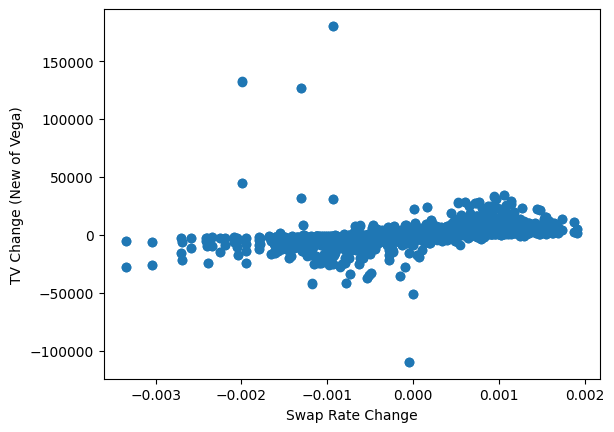

In [40]:
# EDA
plt.scatter(data["Swap Rate Change"], data["TV Change (Net of Vega)"])
plt.xlabel("Swap Rate Change")
plt.ylabel("TV Change (New of Vega)")
# show the legend
plt.show()

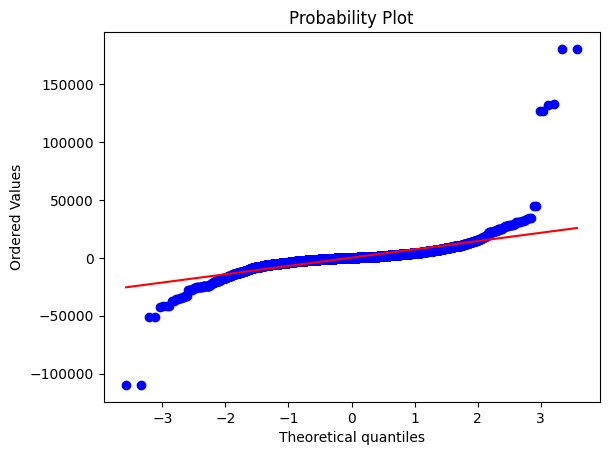

In [41]:
# Normal plot of risk exposure -> fat tail distribution
import scipy.stats as stats
import pylab
stats.probplot( (data["TV Change (Net of Vega)"]), dist="norm", plot=pylab)
pylab.show()

In [42]:
# Model Testing
from sklearn.linear_model import LinearRegression, SGDRegressor, BayesianRidge, HuberRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import  RandomForestRegressor, ExtraTreesRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [43]:
def test_model(model, X_test, y_test):
    score = model.score(X_test, y_test)
    n = len(y_test)
    p = X_test.shape[1]
    adjusted_r2 = 1-(1-score)*(n-1)/(n-p-1)
    print("R^2:", score)
    print("Adjusted R^2:", score)
    y_pred = model.predict(X_test)
    display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
    display.plot()
    plt.show()
    plt.scatter(y_test, y_pred)
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.show()
    return score



In [44]:
# GBR attempt: not a good model
def gradientTrain(X_train, y_train, X_val, y_val):
    params = {"n_estimators": 200, 
          "metric": "rmse",
          "learning_rate": 0.07,           
          "num_leaves": 40,                
          "max_depth": 6,                          
          "early_stopping_round": 10,                         
          "random_state": 42,                         
          "reg_alpha": 0,                          
          "reg_lambda": 1.1,                         
          "min_split_gain": 0.15,                          
          "max_bin": 500,                         
          "top_rate": 0.2,                        
          "other_rate": 0.1,                         
          "training_metric": True,                       
          "verbose": -1, 
          "force_col_wise": True,
          }

    # initialize Gradient Boosting mode;
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
    return model


R^2: 0.5955321146613246
Adjusted R^2: 0.5955321146613246


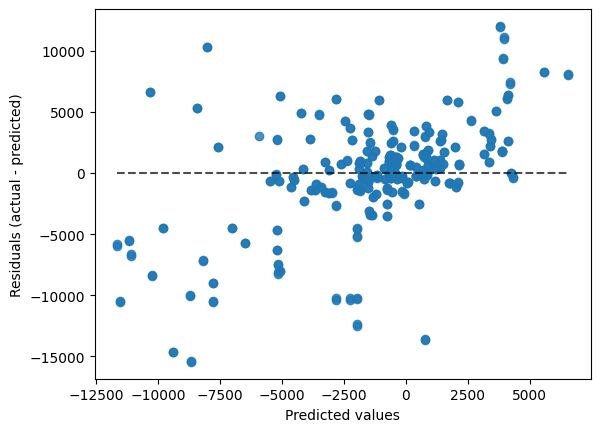

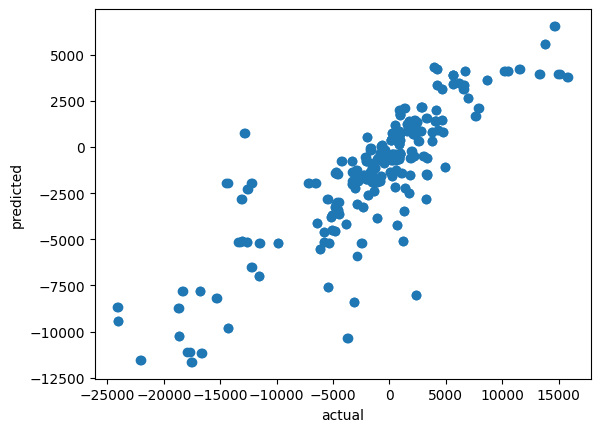

0.5955321146613246

In [45]:
LGBM = gradientTrain(X_train, y_train, X_val, y_val)
test_model(LGBM, X_test, y_test)

R^2: 0.707963797012999
Adjusted R^2: 0.707963797012999


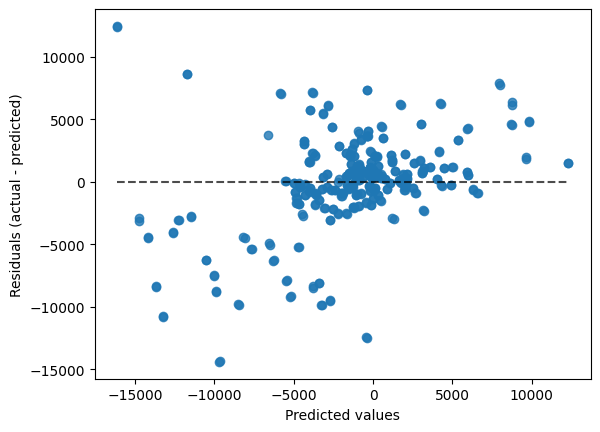

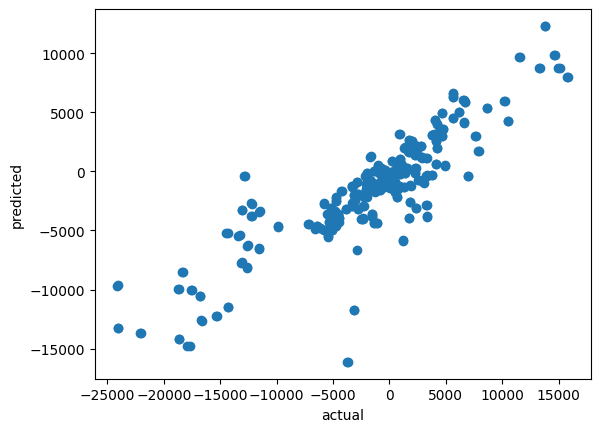

In [46]:
# Extra Trees: best performance and minimum error

params = {"n_estimators": 150, 
          "criterion": "squared_error",           
          "random_state": 42,   
          }

ETmodel = ExtraTreesRegressor(**params)
ETmodel.fit(X_train, y_train)
score_ExtraTrees = test_model(ETmodel, X_test, y_test)

R^2: 0.652174416316146
Adjusted R^2: 0.652174416316146


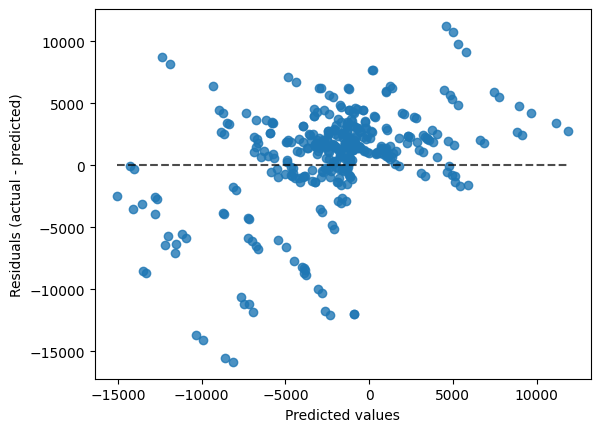

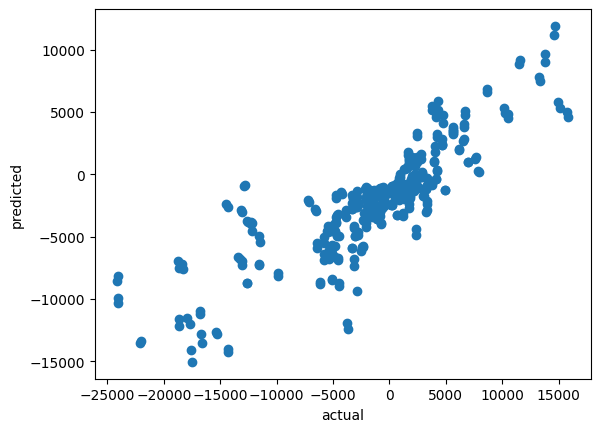

In [47]:
Poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))]).fit(X_train, y_train)
score_poly = test_model(Poly, X_test, y_test)

R^2: 0.5092286525480499
Adjusted R^2: 0.5092286525480499


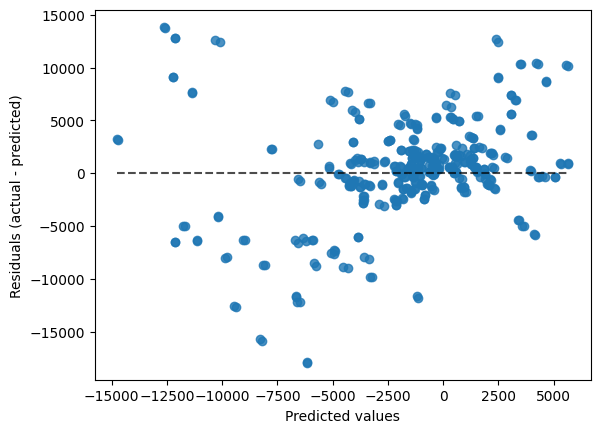

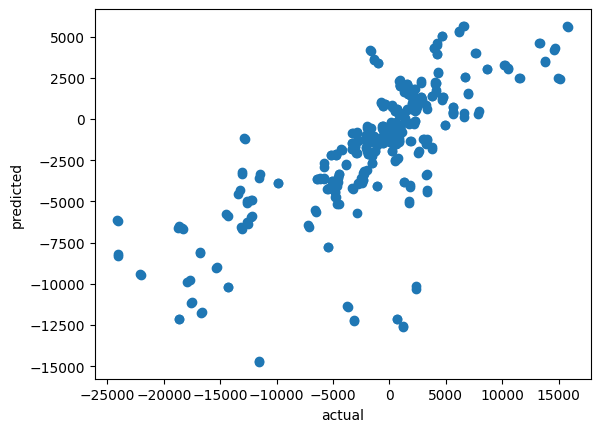

In [48]:
RF = RandomForestRegressor().fit(X_train, y_train)
score_RandomForest = test_model(RF, X_test, y_test)

R^2: 0.3753802117095302
Adjusted R^2: 0.3753802117095302


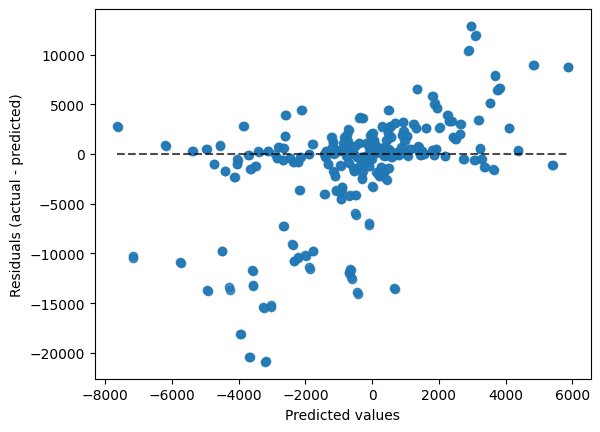

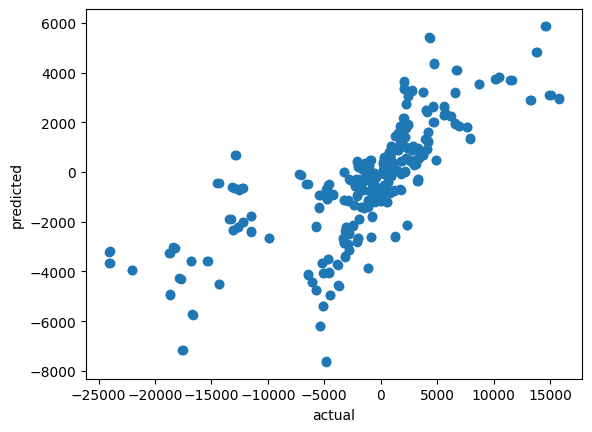

In [49]:
lr = LinearRegression().fit(X_train, y_train)
score_linear = test_model(lr, X_test, y_test)

R^2: -0.20599859460664316
Adjusted R^2: -0.20599859460664316


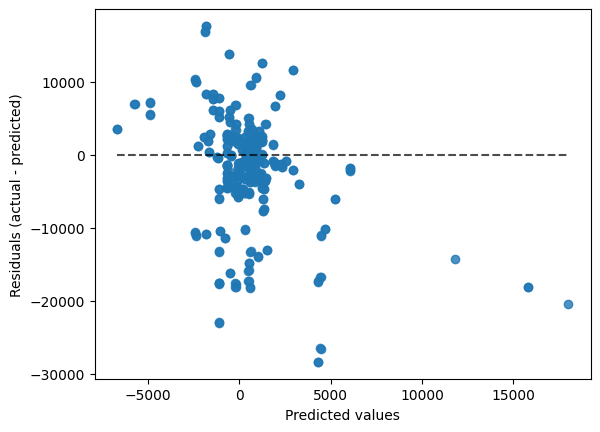

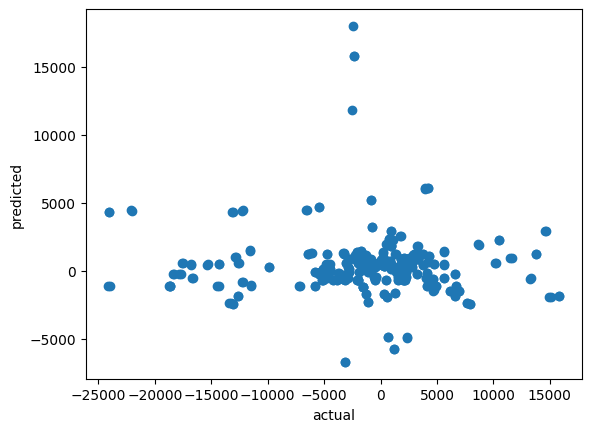

In [50]:
KNN = KNeighborsRegressor().fit(X_train, y_train)
score_KNN = test_model(KNN, X_test, y_test)

R^2: 0.707963797012999
Adjusted R^2: 0.707963797012999


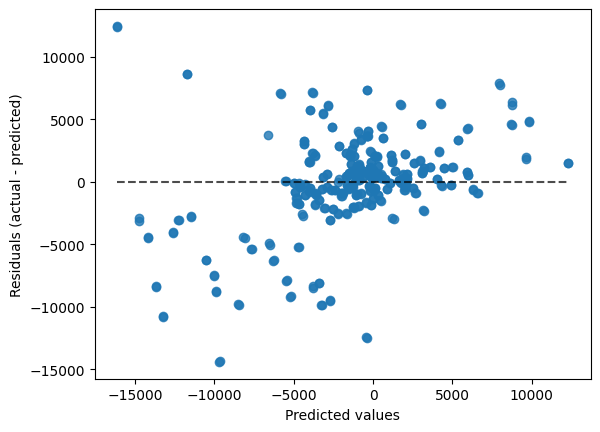

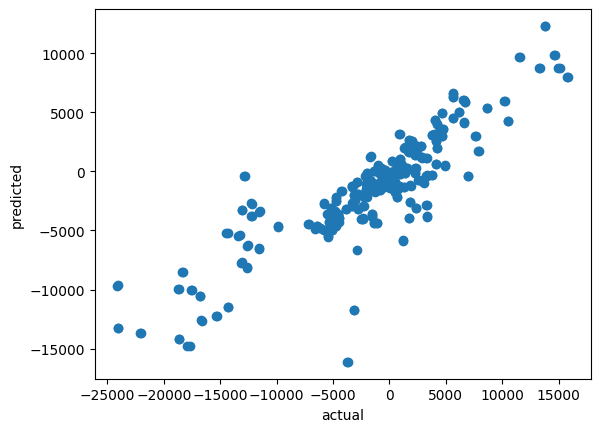

R^2: 0.5955321146613246
Adjusted R^2: 0.5955321146613246


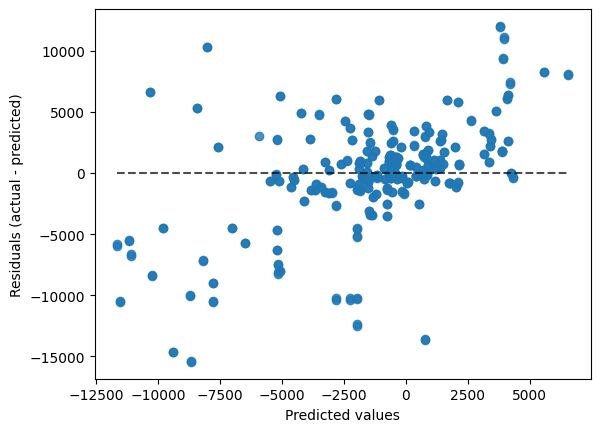

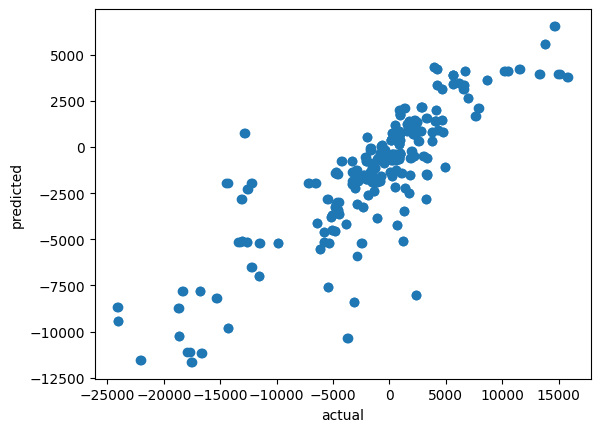

R^2: 0.3753802117095302
Adjusted R^2: 0.3753802117095302


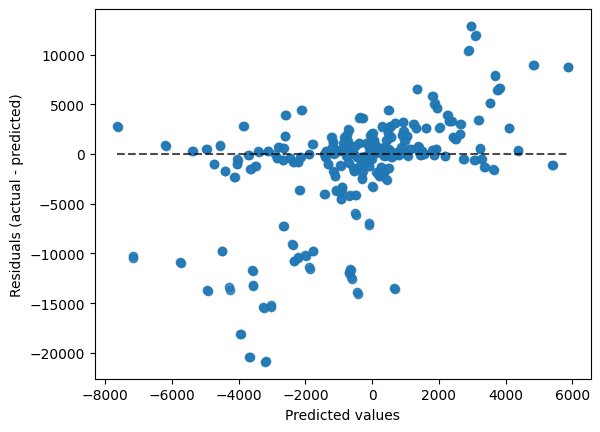

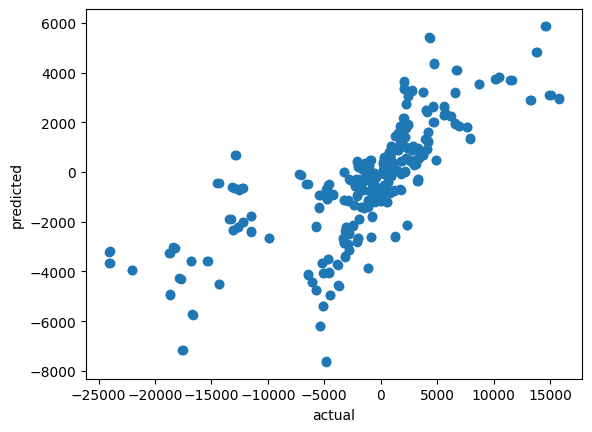

R^2: 0.652174416316146
Adjusted R^2: 0.652174416316146


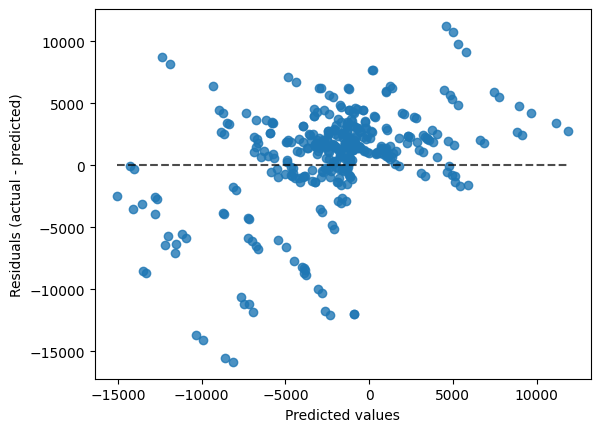

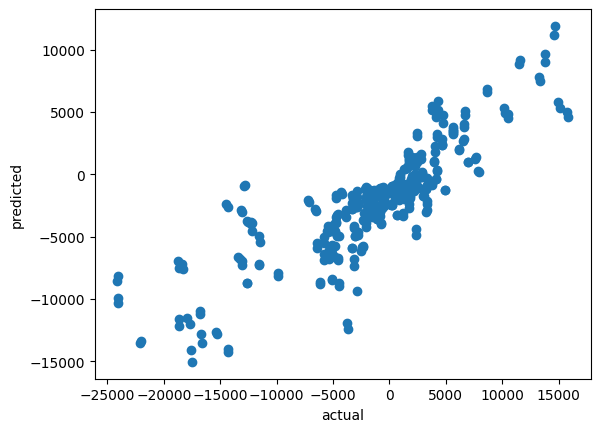

In [54]:
'''# Train Best model with shock data to strengthen the model
data = zero
y = data[target]
X = data[features]
# Split the data into train and test sets
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10
seed = 42
# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state = seed, shuffle=False)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = seed, shuffle=False) 
score_ExtraTrees = test_model(ETmodel, X_test, y_test)
score_LGBM = test_model(LGBM, X_test, y_test)
score_linear = test_model(lr, X_test, y_test)
score_quad = test_model(Poly, X_test, y_test)'''

In [55]:
# Loading Swap Rate Model
from pickle import load
with open("../model/swapRateModel.pkl", "rb") as f:
    swapModel = load(f)

In [56]:
# Validate ideas with with Breach Ratio of Confidence Interval -> BR of less than < 0.01 is good; < 0.05  is satisfactory
def breachRatio( Upper, Lower, X_test, y_test, confidence):
    # Compare actual_confidence and expected confidence
    # Breach Ratio = Abs(actual - expected)
    # Lower: bound; Upper: bound
    lower_bound = Lower
    upper_bound = Upper
    
    inbound = (y_test >= lower_bound) & (y_test <= upper_bound)
    total_obs = y_test.count()
    total_inbound = inbound.sum() # all true value will be summed
    actual_confidence = total_inbound/total_obs 
    breach_ratio, sign = abs(actual_confidence - confidence), (actual_confidence - confidence) > 0
    return breach_ratio, sign

# print message base on Breach ratio calculation
def printBreachRatio(breach_ratio, sign):
    threshold = 0.01
    if breach_ratio < threshold:
        intervalCondition = "Good"
    else:
        intervalCondition = "overbound" if sign else "underbound"
    print("The breach_ratio of Model is:", breach_ratio, "\nThe prediction interval is", intervalCondition)

def swapModelPredict(model, data, confidence):
    import scipy.stats as stats
    # swapModel prediction is in % unit, need to perform scaling when predcing
    
    # features recreation
    features = ['Swap Rate Lag 1', 'Swap Rate Moving Average 2', 'Tenor',  'Swap Rate Std 5']
    X = data
    X = X.rename(columns = {'Swap Rate Lag 1 (Real)': 'Swap Rate Lag 1', 'CMS Tenor': 'Tenor'})
    delay = len(data.loc[data['Value Date'] == "2022-09-02"])
    X['Swap Rate Lag 1'] *= 100 # rescale for model prediction
    X['Swap Rate'] *= 100
    X['Swap Rate Moving Average 2'] = X.shift(delay).groupby(['Tenor'])['Swap Rate'].rolling(2).mean().reset_index(0,drop=True)
    X['Swap Rate Std 5'] = X.shift(delay).groupby(['Tenor'])['Swap Rate'].rolling(5).std().reset_index(0,drop=True)
    X_test = X[features]

    # Prediction
    y_test = data['Swap Rate'] 
    y_pred = model.predict(X_test)
    y_pred /= 100 # prediction rescaling to same unit
    
    def confidenceIntervalN(confidence):
        # finding coef and alpha for required confidence
        # confidence = 1 - 2a
        a = (1 - confidence)/2
        coef = stats.norm.ppf(1-a)
        return a, coef
    
    # Constant Variance Prediction Interval
    def swapPredictionInterval():
        # Prediction Interval Using Const variance assumption and Normal Dist assumption of residuals
        a, coef = confidenceIntervalN(confidence)
        y_test = data['Swap Rate'] 
        # residual variance estimator-> MSE
        # Find MSE and convert to standard deviation
        error = sklearn.metrics.mean_squared_error(y_pred, y_test) ** 0.5 
        # CI = [u +- z*sigma]
        upper, lower = y_pred + coef * error, y_pred - coef * error
        return upper, lower
        
    # width of upper bound and lower bound
    def printWidth(upper, lower):
        width = np.mean(upper-lower)
        print("Average Width of Prediction Interval of Swap Rate is", width, f"(={width*100}%)")
    upper, lower = swapPredictionInterval()
    printWidth(upper, lower)
    breach_ratio, sign = breachRatio(upper, lower, X_test, y_test, confidence)
    printBreachRatio(breach_ratio, sign)
    return y_pred, upper, lower # a pandas DF matching the original DataFrame

In [57]:
# Confidence level
confidence = 0.95
y_pred, upper, lower = swapModelPredict(swapModel, data = zero, confidence)
upper_name = f'Swap Upper ({confidence*100}% Pred)'
lower_name = f'Swap Lower ({confidence*100}% Pred)'
zero['Swap Rate (Pred)'] = y_pred
zero[upper_name] = upper
zero[lower_name] = lower
zero

Average Width of Prediction Interval of Swap Rate is 0.0029492692142701585 (=0.2949269214270159%)
The breach_ratio of Model is: 0.004819277108433773 
The prediction interval is Good


,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,evol,Swap Rate Lag 1 (Real),Vols Lag 1,Vols Change,Vega Lag 1,Vega Risk Exposure,Swap Rate Change,TV Lag 1,TV Change,Vega Risk Exposure (SABR Pred),Vega Risk Exposure (Total SABR Pred),Vega Risk Exposure (Total),TV Change (Net of Vega),Swap Rate (Pred),Swap Upper (95.0% Pred),Swap Lower (95.0% Pred)
36,2022-09-09,dummyTrade1,USD,0,0.00000,-214121.70709,1.00000,2023-09-11,10.00000,5.23230,2,0.03019,0.03019,0.00420,0.03790,0.03370,6,5,0.02599,0.00771,False,0.00771,0.16845,0.41938,0.02971,0.16772,0.00073,6.22331,0.00453,0.00048,-214615.80506,494.09797,1.56613,29.68934,0.44054,493.65743,0.02678,0.02826,0.02531
37,2022-09-09,dummyTrade10,USD,0,0.00000,-611186.14072,1.00000,2023-09-11,10.00000,-65.20325,5,0.02830,0.02830,0.00440,0.03970,0.03530,4,10,0.02390,0.01140,False,0.01140,0.16845,0.41938,0.02797,0.16772,0.00073,-47.37899,-0.03445,0.00033,-612716.87032,1530.72960,-11.92321,85.53580,3.60491,1527.12469,0.02509,0.02656,0.02361
38,2022-09-09,dummyTrade11,USD,0,0.00000,-606894.77273,1.00000,2023-09-11,10.00000,7.85385,10,0.02821,0.02821,0.00460,0.04170,0.03710,4,10,0.02361,0.01349,False,0.01349,0.16845,0.41938,0.02802,0.16772,0.00073,-2.06364,-0.00150,0.00019,-608002.97349,1108.20076,-0.51933,91.44879,-1.31511,1109.51587,0.02513,0.02660,0.02365
39,2022-09-09,dummyTrade12,USD,0,0.00000,-607620.66706,1.00000,2023-09-11,10.00000,15.47400,10,0.02821,0.02821,0.00460,0.04170,0.03710,3,10,0.02361,0.01349,False,0.01349,0.16845,0.41938,0.02802,0.16772,0.00073,24.45988,0.01779,0.00019,-608720.10608,1099.43902,6.15548,104.62291,-1.42624,1100.86526,0.02799,0.02946,0.02651
40,2022-09-09,dummyTrade2,USD,0,0.00000,-214566.58553,1.00000,2023-09-11,10.00000,7.39165,2,0.03019,0.03019,0.00420,0.03790,0.03370,4,5,0.02599,0.00771,False,0.00771,0.16845,0.41938,0.02971,0.16772,0.00073,3.51016,0.00255,0.00048,-215058.64101,492.05549,0.88335,30.93098,0.42374,491.63175,0.02975,0.03122,0.02827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,1.00000,2025-01-13,10.00000,0.78280,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.92804,1.00758,0.03188,0.92354,0.00450,0.75365,0.00339,-0.00016,-201031.68108,278.97326,0.06334,-12.43413,6.94095,272.03231,0.03186,0.03334,0.03039
4016,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,1.00000,2025-01-13,10.00000,-4.09032,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.92804,1.00758,0.03188,0.92354,0.00450,-4.36658,-0.01967,-0.00016,-201241.28870,275.07393,-0.36697,-7.39464,6.94158,268.13234,0.03186,0.03334,0.03039
4017,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,1.00000,2025-01-13,10.00000,-24.00955,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.92804,1.00758,0.03052,0.92354,0.00450,41.87847,0.18864,-0.00069,-509747.56833,2350.90505,3.51945,174.91472,34.62008,2316.28498,0.03048,0.03195,0.02900
4018,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,1.00000,2025-01-13,10.00000,41.98539,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.92804,1.00758,0.03052,0.92354,0.00450,8.07293,0.03637,-0.00069,-510774.02962,2355.99029,0.67845,101.32865,34.87129,2321.11900,0.03048,0.03195,0.02900


In [58]:
# Predicted Upper Change = Upper prediction - last swap rate
zero['Swap Rate Change (Upper Pred)'] = zero[upper_name] - zero['Swap Rate Lag 1 (Real)']
zero['Swap Rate Change (Lower Pred)'] = zero[lower_name] - zero['Swap Rate Lag 1 (Real)']
zero

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,evol,Swap Rate Lag 1 (Real),Vols Lag 1,Vols Change,Vega Lag 1,Vega Risk Exposure,Swap Rate Change,TV Lag 1,TV Change,Vega Risk Exposure (SABR Pred),Vega Risk Exposure (Total SABR Pred),Vega Risk Exposure (Total),TV Change (Net of Vega),Swap Rate (Pred),Swap Upper (95.0% Pred),Swap Lower (95.0% Pred),Swap Rate Change (Upper Pred),Swap Rate Change (Lower Pred)
36,2022-09-09,dummyTrade1,USD,0,0.00000,-214121.70709,1.00000,2023-09-11,10.00000,5.23230,2,0.03019,0.03019,0.00420,0.03790,0.03370,6,5,0.02599,0.00771,False,0.00771,0.16845,0.41938,0.02971,0.16772,0.00073,6.22331,0.00453,0.00048,-214615.80506,494.09797,1.56613,29.68934,0.44054,493.65743,0.02678,0.02826,0.02531,-0.00145,-0.00440
37,2022-09-09,dummyTrade10,USD,0,0.00000,-611186.14072,1.00000,2023-09-11,10.00000,-65.20325,5,0.02830,0.02830,0.00440,0.03970,0.03530,4,10,0.02390,0.01140,False,0.01140,0.16845,0.41938,0.02797,0.16772,0.00073,-47.37899,-0.03445,0.00033,-612716.87032,1530.72960,-11.92321,85.53580,3.60491,1527.12469,0.02509,0.02656,0.02361,-0.00141,-0.00436
38,2022-09-09,dummyTrade11,USD,0,0.00000,-606894.77273,1.00000,2023-09-11,10.00000,7.85385,10,0.02821,0.02821,0.00460,0.04170,0.03710,4,10,0.02361,0.01349,False,0.01349,0.16845,0.41938,0.02802,0.16772,0.00073,-2.06364,-0.00150,0.00019,-608002.97349,1108.20076,-0.51933,91.44879,-1.31511,1109.51587,0.02513,0.02660,0.02365,-0.00142,-0.00437
39,2022-09-09,dummyTrade12,USD,0,0.00000,-607620.66706,1.00000,2023-09-11,10.00000,15.47400,10,0.02821,0.02821,0.00460,0.04170,0.03710,3,10,0.02361,0.01349,False,0.01349,0.16845,0.41938,0.02802,0.16772,0.00073,24.45988,0.01779,0.00019,-608720.10608,1099.43902,6.15548,104.62291,-1.42624,1100.86526,0.02799,0.02946,0.02651,0.00144,-0.00151
40,2022-09-09,dummyTrade2,USD,0,0.00000,-214566.58553,1.00000,2023-09-11,10.00000,7.39165,2,0.03019,0.03019,0.00420,0.03790,0.03370,4,5,0.02599,0.00771,False,0.00771,0.16845,0.41938,0.02971,0.16772,0.00073,3.51016,0.00255,0.00048,-215058.64101,492.05549,0.88335,30.93098,0.42374,491.63175,0.02975,0.03122,0.02827,0.00151,-0.00144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,1.00000,2025-01-13,10.00000,0.78280,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.92804,1.00758,0.03188,0.92354,0.00450,0.75365,0.00339,-0.00016,-201031.68108,278.97326,0.06334,-12.43413,6.94095,272.03231,0.03186,0.03334,0.03039,0.00146,-0.00149
4016,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,1.00000,2025-01-13,10.00000,-4.09032,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.92804,1.00758,0.03188,0.92354,0.00450,-4.36658,-0.01967,-0.00016,-201241.28870,275.07393,-0.36697,-7.39464,6.94158,268.13234,0.03186,0.03334,0.03039,0.00146,-0.00149
4017,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,1.00000,2025-01-13,10.00000,-24.00955,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.92804,1.00758,0.03052,0.92354,0.00450,41.87847,0.18864,-0.00069,-509747.56833,2350.90505,3.51945,174.91472,34.62008,2316.28498,0.03048,0.03195,0.02900,0.00144,-0.00151
4018,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,1.00000,2025-01-13,10.00000,41.98539,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.92804,1.00758,0.03052,0.92354,0.00450,8.07293,0.03637,-0.00069,-510774.02962,2355.99029,0.67845,101.32865,34.87129,2321.11900,0.03048,0.03195,0.02900,0.00144,-0.00151


R^2 = 0.9532421828275763


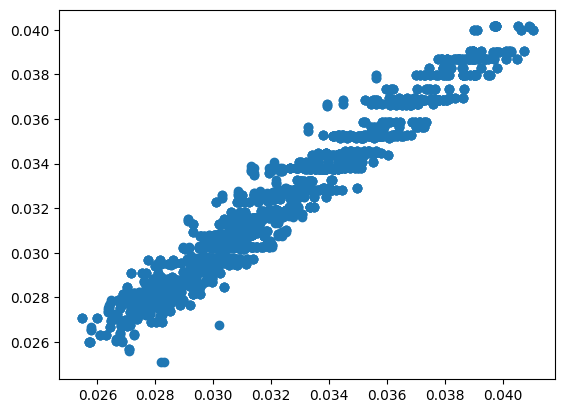

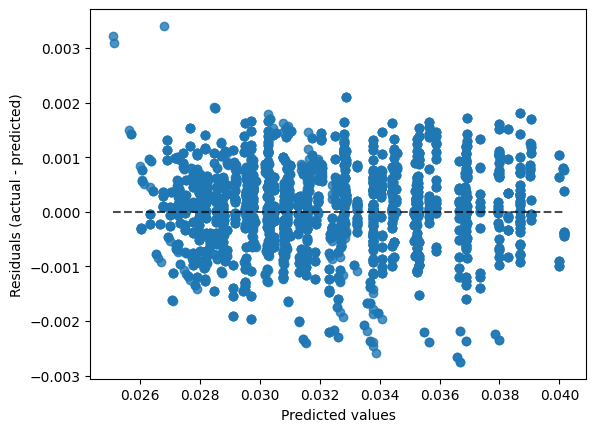

In [59]:
y_test = zero['Swap Rate']
plt.scatter(y_test, y_pred)
# Calculate R^2 and R^2 adj to evaluate model adequacy
R_sq = sklearn.metrics.r2_score(y_test, y_pred)
#n = X_test.shape[0]
#p = X_test.shape[1]
#adjusted_r2 = 1-(1-R_sq)*(n-1)/(n-p-1)
print("R^2 =", R_sq) 
#print("Adjusted R^2 =", adjusted_r2)
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()

In [60]:
# The residual plot supported the constant variance residual assumption

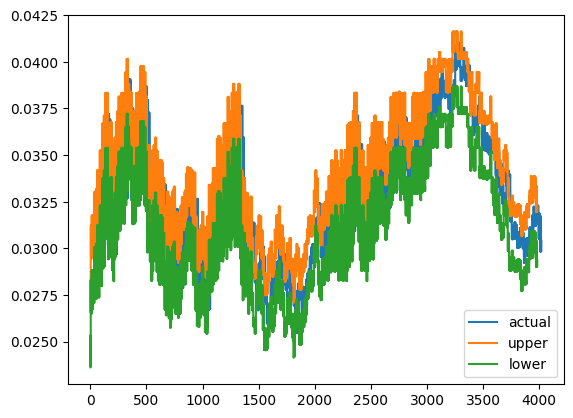

In [61]:
# Notes: First 5 days will have high residual since Std 5 features is not filled

plt.plot(y_test, label = "actual")
#plt.plot(y_pred, label = "prediction")
plt.plot(upper, label = "upper")
plt.plot(lower, label = "lower")
# show the legend
plt.legend()
plt.show()

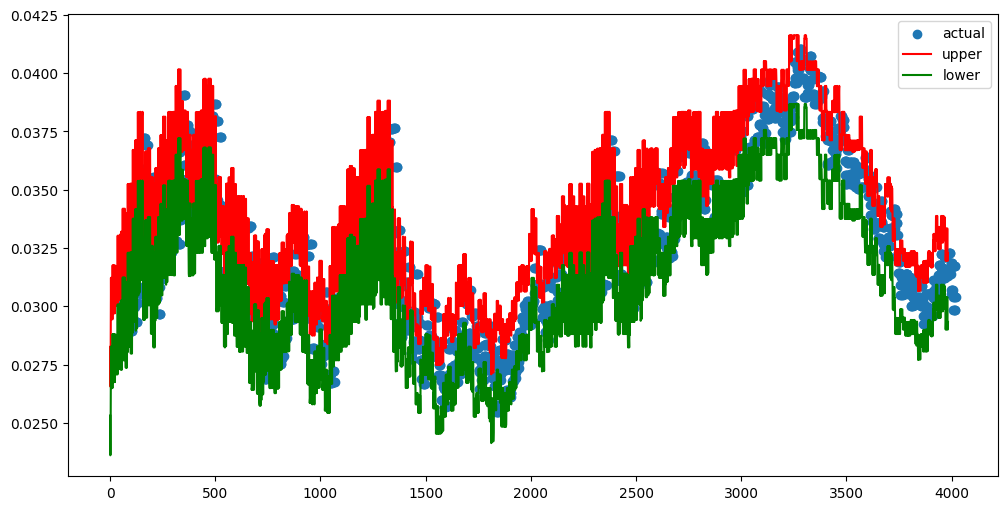

In [62]:
# Notes: First 5 days will have high residual since Std 5 features is not filled
plt.figure(figsize=(12,6))
plt.scatter(y_test.index, y_test, label = "actual")
#plt.plot(y_pred, label = "prediction")
plt.plot(upper, label = "upper", color = "Red")
plt.plot(lower, label = "lower", color = "Green")
# show the legend
plt.legend()
plt.show()

In [63]:
# IR model -> given a swap rate change prediction -> output corresponding TV change

# Next Step: Find Swap rate Change (upper + lower) * IR model prediction to find predicted TV change (90% Condifence Interval)
# Then validate with 90% Condeidence The value at risk and actual risk (how many the actual TV chagne is in bound of the Value at risk,
# Can calculate tail risk wtih by averaging the outliers value

In [64]:
# Give Prediction of IR after having Swap Rate model prediction interval 

def IRmodelPredict(data, model):
    X_test = data[features].drop(columns = {'Swap Rate Change'})
    #X_test.columns = X_test.columns.str.replace(' ', '_')
    # drop swap rate change columns in features
    # Replace with upper and lower bound prediction
    #Upper
    X_upper = X_test
    X_test['Swap Rate Change'] = data['Swap Rate Change (Upper Pred)']
    X_upper = X_test[features]
    Y_upperPred = model.predict(X_upper)
    # Lower
    X_lower = X_test
    X_test['Swap Rate Change'] =  data['Swap Rate Change (Lower Pred)']
    X_lower = X_test[features]
    Y_lowerPred = model.predict(X_lower)
    breach_ratio, sign = breachRatio(Y_upperPred, Y_lowerPred, X_test, y_test, confidence)
    printBreachRatio(breach_ratio, sign)
    return Y_upperPred, Y_lowerPred

In [65]:
# TV upper bound and lower bound is produced

curr = zero
Y_upperPred, Y_lowerPred = IRmodelPredict(curr, ETmodel)
curr['TV Change (Upper Pred)'] = Y_upperPred
curr['TV Change (Lower Pred)'] = Y_lowerPred
curr

The breach_ratio of Model is: 0.009487951807228834 
The prediction interval is Good


,Value Date,Trade Name,Trade Currency,Zero Rate Shock,Zero Rate Shock (DEC),TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,CMS Tenor,Swap Rate,Swap Rate (Shocked),lower_bound,upper_bound,bound width,month_pay_frequency,year_maturity,Distance_lower (Shocked),Distance_upper (Shocked),Out of Bound,Swap_Bound Distance,Vols,evol,Swap Rate Lag 1 (Real),Vols Lag 1,Vols Change,Vega Lag 1,Vega Risk Exposure,Swap Rate Change,TV Lag 1,TV Change,Vega Risk Exposure (SABR Pred),Vega Risk Exposure (Total SABR Pred),Vega Risk Exposure (Total),TV Change (Net of Vega),Swap Rate (Pred),Swap Upper (95.0% Pred),Swap Lower (95.0% Pred),Swap Rate Change (Upper Pred),Swap Rate Change (Lower Pred),TV Change (Upper Pred),TV Change (Lower Pred)
36,2022-09-09,dummyTrade1,USD,0,0.00000,-214121.70709,1.00000,2023-09-11,10.00000,5.23230,2,0.03019,0.03019,0.00420,0.03790,0.03370,6,5,0.02599,0.00771,False,0.00771,0.16845,0.41938,0.02971,0.16772,0.00073,6.22331,0.00453,0.00048,-214615.80506,494.09797,1.56613,29.68934,0.44054,493.65743,0.02678,0.02826,0.02531,-0.00145,-0.00440,-1629.42504,-5057.58461
37,2022-09-09,dummyTrade10,USD,0,0.00000,-611186.14072,1.00000,2023-09-11,10.00000,-65.20325,5,0.02830,0.02830,0.00440,0.03970,0.03530,4,10,0.02390,0.01140,False,0.01140,0.16845,0.41938,0.02797,0.16772,0.00073,-47.37899,-0.03445,0.00033,-612716.87032,1530.72960,-11.92321,85.53580,3.60491,1527.12469,0.02509,0.02656,0.02361,-0.00141,-0.00436,-8740.94771,-23139.31095
38,2022-09-09,dummyTrade11,USD,0,0.00000,-606894.77273,1.00000,2023-09-11,10.00000,7.85385,10,0.02821,0.02821,0.00460,0.04170,0.03710,4,10,0.02361,0.01349,False,0.01349,0.16845,0.41938,0.02802,0.16772,0.00073,-2.06364,-0.00150,0.00019,-608002.97349,1108.20076,-0.51933,91.44879,-1.31511,1109.51587,0.02513,0.02660,0.02365,-0.00142,-0.00437,-8815.21997,-21968.25016
39,2022-09-09,dummyTrade12,USD,0,0.00000,-607620.66706,1.00000,2023-09-11,10.00000,15.47400,10,0.02821,0.02821,0.00460,0.04170,0.03710,3,10,0.02361,0.01349,False,0.01349,0.16845,0.41938,0.02802,0.16772,0.00073,24.45988,0.01779,0.00019,-608720.10608,1099.43902,6.15548,104.62291,-1.42624,1100.86526,0.02799,0.02946,0.02651,0.00144,-0.00151,7570.49517,-9133.69622
40,2022-09-09,dummyTrade2,USD,0,0.00000,-214566.58553,1.00000,2023-09-11,10.00000,7.39165,2,0.03019,0.03019,0.00420,0.03790,0.03370,4,5,0.02599,0.00771,False,0.00771,0.16845,0.41938,0.02971,0.16772,0.00073,3.51016,0.00255,0.00048,-215058.64101,492.05549,0.88335,30.93098,0.42374,491.63175,0.02975,0.03122,0.02827,0.00151,-0.00144,1386.93397,-1625.61380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,2024-01-12,dummyTrade5,USD,0,0.00000,-200752.70782,1.00000,2025-01-13,10.00000,0.78280,10,0.03171,0.03171,0.00460,0.04170,0.03710,4,5,0.02711,0.00999,False,0.00999,0.92804,1.00758,0.03188,0.92354,0.00450,0.75365,0.00339,-0.00016,-201031.68108,278.97326,0.06334,-12.43413,6.94095,272.03231,0.03186,0.03334,0.03039,0.00146,-0.00149,3952.96129,-4646.76742
4016,2024-01-12,dummyTrade6,USD,0,0.00000,-200966.21477,1.00000,2025-01-13,10.00000,-4.09032,10,0.03171,0.03171,0.00460,0.04170,0.03710,3,5,0.02711,0.00999,False,0.00999,0.92804,1.00758,0.03188,0.92354,0.00450,-4.36658,-0.01967,-0.00016,-201241.28870,275.07393,-0.36697,-7.39464,6.94158,268.13234,0.03186,0.03334,0.03039,0.00146,-0.00149,3952.05472,-4652.38013
4017,2024-01-12,dummyTrade7,USD,0,0.00000,-507396.66328,1.00000,2025-01-13,10.00000,-24.00955,2,0.02983,0.02983,0.00420,0.03790,0.03370,6,10,0.02563,0.00807,False,0.00807,0.92804,1.00758,0.03052,0.92354,0.00450,41.87847,0.18864,-0.00069,-509747.56833,2350.90505,3.51945,174.91472,34.62008,2316.28498,0.03048,0.03195,0.02900,0.00144,-0.00151,8553.45540,-14331.14526
4018,2024-01-12,dummyTrade8,USD,0,0.00000,-508418.03933,1.00000,2025-01-13,10.00000,41.98539,2,0.02983,0.02983,0.00420,0.03790,0.03370,4,10,0.02563,0.00807,False,0.00807,0.92804,1.00758,0.03052,0.92354,0.00450,

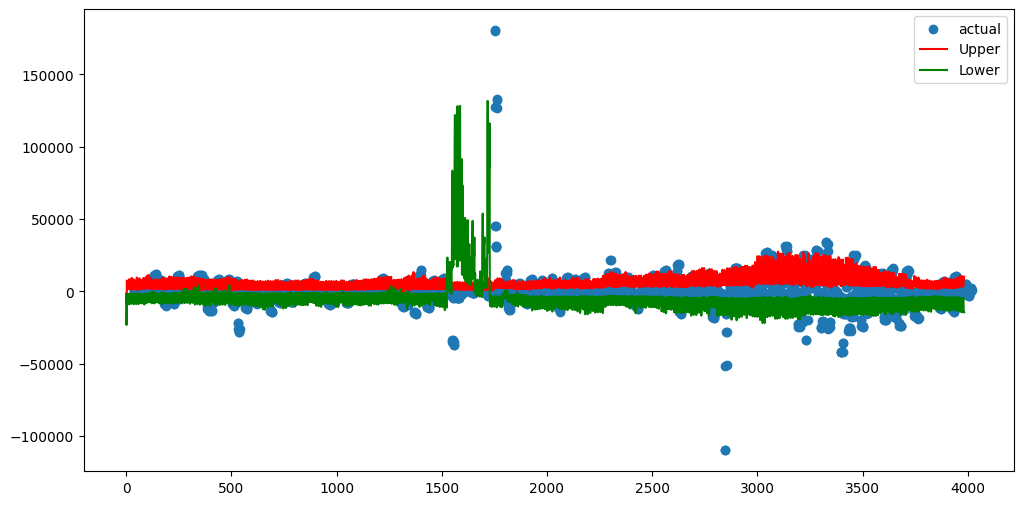

In [66]:
# Plotting actual TV change and upper bound and lower bound predicted

# Notes: an overlapped behavior of upper and lower bound is observed. 
# This is because of non linear relationship between TV change and features. As shown in residual plots of most model. 
# Further investigation is required for certain outliers due to weird behavior in 1 day shocking 200000 USD of trade value

plt.figure(figsize=(12,6))
plt.scatter(y.index, y, label = "actual")
#plt.plot(y_pred, label = "prediction")
#plt.plot(upper, label = "upper", color = "Red")
#plt.plot(lower, label = "lower", color = "Green")
# show the legend


#plt.plot(y, label = "Actual")
plt.plot(Y_upperPred, label = "Upper", color = "Red")
plt.plot(Y_lowerPred, label = "Lower", color = "Green")
plt.legend()
plt.show()

In [67]:
## Vega Risk model

In [69]:
# Plotting Vega Exposure

vega_pred = zero['Vega Risk Exposure (Total SABR Pred)']
vega_test = zero['Vega Risk Exposure (Total)']

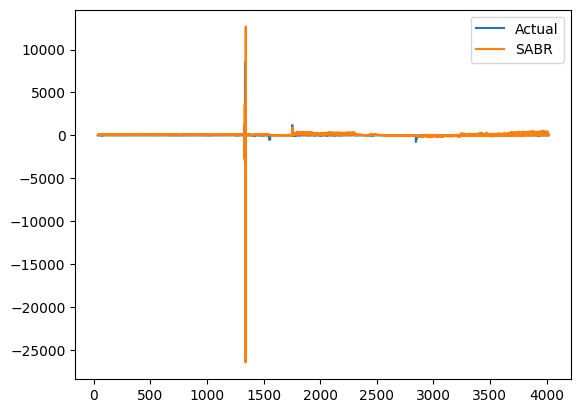

In [75]:
plt.plot(vega_test, label = "Actual")
plt.plot(vega_pred, label = "SABR")
plt.legend()
plt.show()